# Polynomial prediction with a homogenous MLP model

### env management

In [2]:
%load_ext autoreload
%reload_ext autoreload
# %env XLA_PYTHON_CLIENT_MEM_FRACTION=0.3

### imports and setup

In [3]:
import jax
import numpy as np
import jax.numpy as jnp
import equinox as eqx
import optax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import Normalize
import matplotlib.style as mplstyle
import seaborn as sns

from NeuralNetworkEvolution.config import MLPConfig
from NeuralNetworkEvolution.activations import sin
from NeuralNetworkEvolution.mlp import CustomMLP, mlp_plot

import os
import sys
import time
import logging

In [4]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='vlag', font='serif',
            font_scale=2, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [5]:
class MidpointNormalize(Normalize):
    """
    Normalize and shift the colormap to center 0
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        (vmin, vmax, midpoint) = self.vmin, self.vmax, self.midpoint
        if vmin is None or vmax is None:
            vmin, vmax = np.min(value), np.max(value)
        if midpoint is None:
            midpoint = (vmin + vmax) / 2
        result = np.ma.masked_array(np.interp(value, [vmin, midpoint, vmax], [0, 0.5, 1]))
        if is_scalar:
            result = np.atleast_1d(result)[0]
        return result

### config

In [6]:
jax.config.update('jax_platform_name', 'cpu')

In [7]:
input_size = 1
hidden_sizes = [16, 16] 
min_neurons = 32
max_neurons = 32
output_size = 1
initial_activation_list = [jax.nn.tanh]
activation_list = [jax.nn.tanh]
optimizer = optax.adabelief
bias = False
num_epochs = 25000
intervene_every = 100
seed = 0
key = jax.random.PRNGKey(seed)
threshold = 1e-4
grad_norm_threshold = 1e-3
n_samples = 20000
test_size = 0.2
learning_rate = 3e-4

act_string = "_".join([act.__name__ for act in initial_activation_list])

config = MLPConfig(input_size=input_size,
                output_size=output_size,
                hidden_sizes=hidden_sizes,
                initial_activation_list=initial_activation_list,
                seed=seed)

In [8]:
config.__dict__.update({'n_samples': n_samples,
                        'learning_rate': learning_rate,
                        'num_epochs': num_epochs,
                        'intervene_every': intervene_every,
                        'threshold': threshold,
                        'activation_list': activation_list})

In [9]:
# jax.config.update("jax_enable_x64", True)

Description = f"Homo_{act_string}_poly_static_{optimizer.__name__}_no_bias_{max_neurons}_{hidden_sizes[0]}_{hidden_sizes[1]}_{num_epochs}_{seed}"
fig_folder = f"../figures/single_run/{Description}"
out_folder = f"../output/single_run/{Description}"
os.makedirs(fig_folder, exist_ok=True)
os.makedirs(out_folder, exist_ok=True)

### logging

In [10]:
print(f"# devices: {jax.local_device_count()}")

logging.basicConfig(level=logging.INFO, filename=f"{out_folder}/info.log", filemode="w")
console = logging.StreamHandler(sys.stdout)
console.setLevel(logging.INFO)
logging.getLogger("").addHandler(console)
logging.info(f"Description: {Description}")
logging.info(f"jax backend: {jax.lib.xla_bridge.get_backend().platform}")
logging.info(f"jax devices: {jax.devices()}")

# devices: 1
Description: Homo_tanh_poly_deterministic_addition_adabelief_no_bias_min_32_max_32_16_16_25000_100_0
jax backend: cpu
jax devices: [CpuDevice(id=0)]


### data

In [11]:
def poly(x):
    """
    7th degree polynomial to predict
    """
    return (x - 3)*(x - 2)*(x - 1)*x*(x + 1)*(x + 2)*(x + 3)

In [12]:
x = jnp.linspace(-3, 3, n_samples).reshape(-1, 1)
y = poly(x)

In [13]:
scaler = MinMaxScaler(feature_range=(-1,1))
x_scaled, y_scaled = scaler.fit_transform(x), scaler.fit_transform(y)

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, random_state=seed)


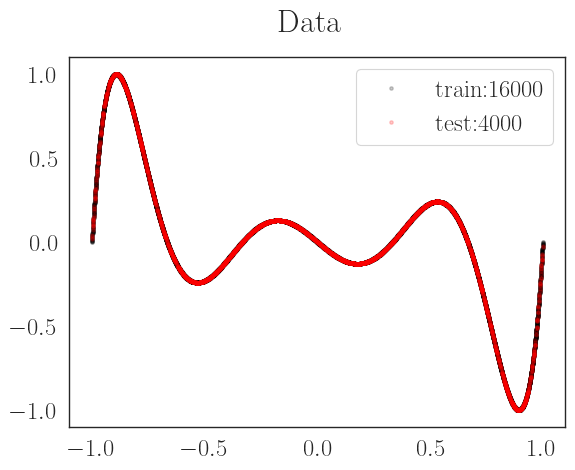

In [15]:
plt.plot(x_train, y_train, "k.", alpha=0.2, label=f"train:{len(x_train)}")
plt.plot(x_test, y_test, "r.", alpha = 0.2, label=f"test:{len(x_test)}")
plt.legend()
plt.suptitle("Data")
plt.savefig(f"{fig_folder}/train_test_data.png")
plt.savefig(f"{fig_folder}/train_test_data.pdf")
plt.savefig(f"{fig_folder}/train_test_data.svg", format='svg', bbox_inches='tight')

### training and eval scheme

In [16]:
def initialize_optimizer_state(mlp, optimizer):
    """
    Optimizer initialization that filters for float arrays in the jax pytrees
    """
    return optimizer.init(eqx.filter(mlp, eqx.is_inexact_array))

In [17]:
@eqx.filter_value_and_grad()
def compute_loss(mlp, x, y):
    pred = jax.vmap(mlp)(x)
    return jnp.mean((pred - y) ** 2)

In [18]:
@eqx.filter_jit()
def train_step(mlp, x, y, opt_state, opt_update):
    loss, grads = compute_loss(mlp, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    mlp = eqx.apply_updates(mlp, updates)
    return loss, mlp, opt_state

In [19]:
@eqx.filter_jit()
def test_step(mlp, x, y):
    return compute_loss(mlp, x, y)[0]

In [20]:
@eqx.filter_jit()
def grad_norm(grads):
    return jnp.sqrt(sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(grads)))

### initializing MLP

In [21]:
mlp = CustomMLP(config)
init_neurons = sum(mlp.get_shape())-output_size
logging.info(f"Number of neurons at start: {init_neurons}")

Number of neurons at start: 32


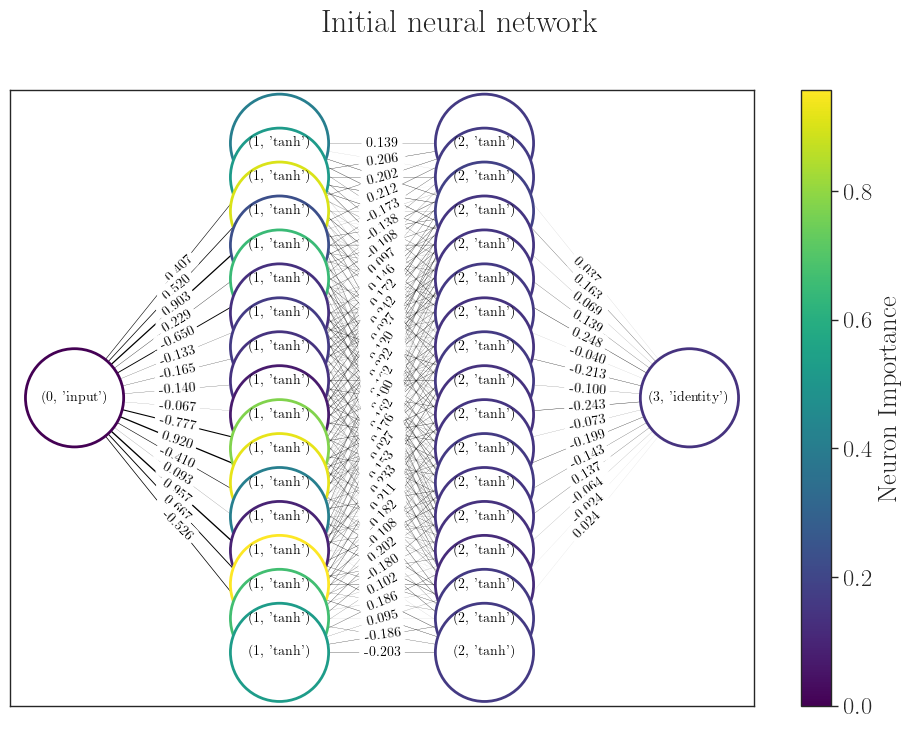

In [22]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.suptitle("Initial neural network")
plt.savefig(f"{fig_folder}/initial_graph.png")
plt.savefig(f"{fig_folder}/initial_graph.pdf")
plt.savefig(f"{fig_folder}/initial_graph.svg", format='svg', bbox_inches='tight')

In [23]:
initial_adjacency_matrix = mlp.adjacency_matrix()

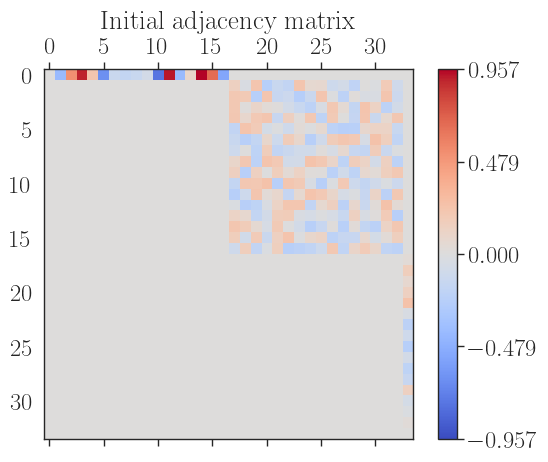

In [24]:
max_wt = np.max(np.abs(initial_adjacency_matrix))
norm = MidpointNormalize(vmin=-max_wt, vmax=max_wt, midpoint=0)
cmap = plt.get_cmap('coolwarm')

fig, ax = plt.subplots()
cax = ax.matshow(initial_adjacency_matrix, cmap=cmap, norm=norm)
cbar = fig.colorbar(cax, ticks=[-max_wt,
                                -max_wt/2, 
                                0,
                                max_wt/2,
                                max_wt])

# plt.colorbar()
plt.title("Initial adjacency matrix")
plt.savefig(f"{fig_folder}/initial_adjacency_matrix.png")
plt.savefig(f"{fig_folder}/initial_adjacency_matrix.pdf")
plt.savefig(f"{fig_folder}/initial_adjacency_matrix.svg", format='svg', bbox_inches='tight')

### initializing optimizer

In [25]:
opt = optimizer(learning_rate=learning_rate)
opt_state = initialize_optimizer_state(mlp, opt)

### training

In [26]:
train_loss_history = []
test_loss_history = []
node_history = []
grad_norm_history = []
graph_history = []
update_history = []


In [27]:
for epoch in range(num_epochs):

    train_loss, mlp, opt_state = train_step(mlp, x_train, y_train, opt_state, opt.update)
    _, grads  = compute_loss(mlp, x_train, y_train)
    grad_norm_val = grad_norm(grads)
    n_neurons = sum(mlp.get_shape()) - output_size

    logging.info(f"Epoch {epoch :03d}, Loss: {train_loss.item()}, Neurons: {n_neurons}, Grad norm: {grad_norm_val :.3e}")
    train_loss_history.append((epoch, train_loss))
    grad_norm_history.append((epoch,grad_norm_val))
    node_history.append((epoch, n_neurons))

    key, add_key, sub_key, prob_key = jax.random.split(key,4)

    if (epoch + 1) % intervene_every == 0 and epoch!=num_epochs-1: # intervene if gradient norm is below threshold, but not at last epoch
        test_loss = test_step(mlp, x_test, y_test)
        logging.info(f"Epoch {epoch :03d}, Test loss: {test_loss.item()}")
        test_loss_history.append((epoch,test_loss))



Epoch 000, Loss: 0.23772010207176208, Neurons: 32, Grad norm: 6.786e-01
Epoch 001, Loss: 0.23551715910434723, Neurons: 32, Grad norm: 6.712e-01
Epoch 002, Loss: 0.23322641849517822, Neurons: 32, Grad norm: 6.635e-01
Epoch 003, Loss: 0.23085060715675354, Neurons: 32, Grad norm: 6.556e-01
Epoch 004, Loss: 0.22839297354221344, Neurons: 32, Grad norm: 6.474e-01
Epoch 005, Loss: 0.2258571833372116, Neurons: 32, Grad norm: 6.389e-01
Epoch 006, Loss: 0.223247691988945, Neurons: 32, Grad norm: 6.302e-01
Epoch 007, Loss: 0.2205694615840912, Neurons: 32, Grad norm: 6.212e-01
Epoch 008, Loss: 0.217828169465065, Neurons: 32, Grad norm: 6.121e-01
Epoch 009, Loss: 0.21502983570098877, Neurons: 32, Grad norm: 6.028e-01
Epoch 010, Loss: 0.2121809720993042, Neurons: 32, Grad norm: 5.932e-01
Epoch 011, Loss: 0.2092883139848709, Neurons: 32, Grad norm: 5.835e-01
Epoch 012, Loss: 0.20635870099067688, Neurons: 32, Grad norm: 5.737e-01
Epoch 013, Loss: 0.203399196267128, Neurons: 32, Grad norm: 5.638e-01
Ep

KeyboardInterrupt: 

In [ ]:
np.savetxt(f"{out_folder}/neurons.txt", node_history)
np.savetxt(f"{out_folder}/train_loss.txt", train_loss_history)
np.savetxt(f"{out_folder}/test_loss.txt", test_loss_history)
np.savetxt(f"{out_folder}/grad_norm.txt", grad_norm_history)

### evaluation

In [ ]:
y_pred = jax.vmap(mlp)(x_test)
test_mse = jnp.mean((y_pred - y_test) ** 2)
plt.figure(figsize=(10, 6))
plt.plot(x_test, y_test, "b.", alpha=0.2, label="True Poly Function")
plt.plot(x_test, y_pred, "r.", alpha=0.2, label="MLP Predictions\n Test MSE: {:.4e}".format(test_mse))
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("MLP Approximation of polynomial Function")
plt.savefig(f"{fig_folder}/polynomial_approximation.png")
plt.savefig(f"{fig_folder}/polynomial_approximation.pdf")
plt.savefig(f"{fig_folder}/polynomial_approximation.svg", format='svg', bbox_inches='tight')


NameError: name 'jax' is not defined

In [ ]:
final_adjacency_matrix = mlp.adjacency_matrix()

In [ ]:
np.savetxt(f"{out_folder}/final_adjacency_matrix.txt", final_adjacency_matrix)

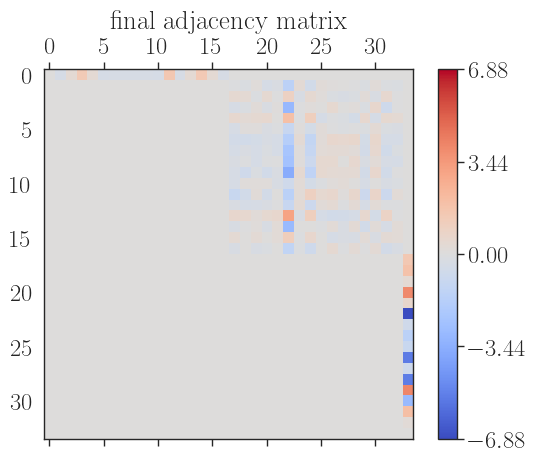

In [ ]:
max_wt = np.max(np.abs(final_adjacency_matrix))
norm = MidpointNormalize(vmin=-max_wt, vmax=max_wt, midpoint=0)
cmap = plt.get_cmap('coolwarm')

fig, ax = plt.subplots()
cax = ax.matshow(final_adjacency_matrix, cmap=cmap, norm=norm)
cbar = fig.colorbar(cax, ticks=[-max_wt,
                                -max_wt/2, 
                                0,
                                max_wt/2,
                                max_wt])

# plt.colorbar()
plt.title("final adjacency matrix")
plt.savefig(f"{fig_folder}/final_adjacency_matrix.png")
plt.savefig(f"{fig_folder}/final_adjacency_matrix.pdf")
plt.savefig(f"{fig_folder}/final_adjacency_matrix.svg", format='svg', bbox_inches='tight')

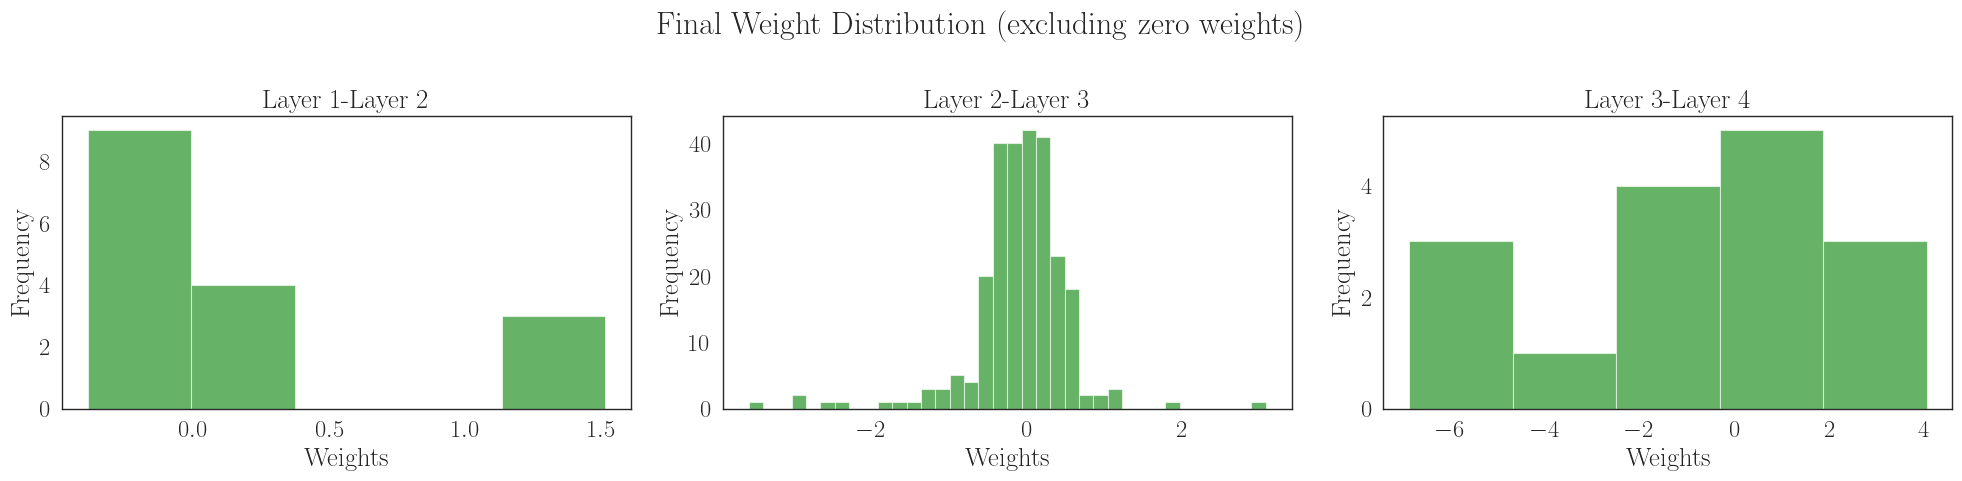

In [ ]:
sub_matrices = np.split(final_adjacency_matrix, np.cumsum([mlp.input_size] + mlp.get_shape())[:-1])[:-1]

fig, axs = plt.subplots(1, len(sub_matrices), figsize=(20, 5))

for i, (sub_matrix, ax) in enumerate(zip(sub_matrices, axs), start=1):
    weights = sub_matrix.flatten()
    weights = weights[weights != 0]
    ax.hist(weights, bins="auto", density=False, alpha=0.6, color='g')
    ax.set_xlabel('Weights')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Layer {i}-Layer {i+1} ')

plt.suptitle('Final Weight Distribution (excluding zero weights)')
plt.tight_layout()
plt.savefig(f"{fig_folder}/final_weight_distribution.pdf")
plt.savefig(f"{fig_folder}/final_weight_distribution.png")
plt.savefig(f"{fig_folder}/final_weight_distribution.svg", format='svg', bbox_inches='tight')
plt.show()

In [ ]:
train_epochs, train_loss = zip(*train_loss_history)
test_epochs, test_loss = zip(*test_loss_history)
grad_epochs, grad_norm_val = zip(*grad_norm_history)
node_epochs, n_neurons = zip(*node_history)

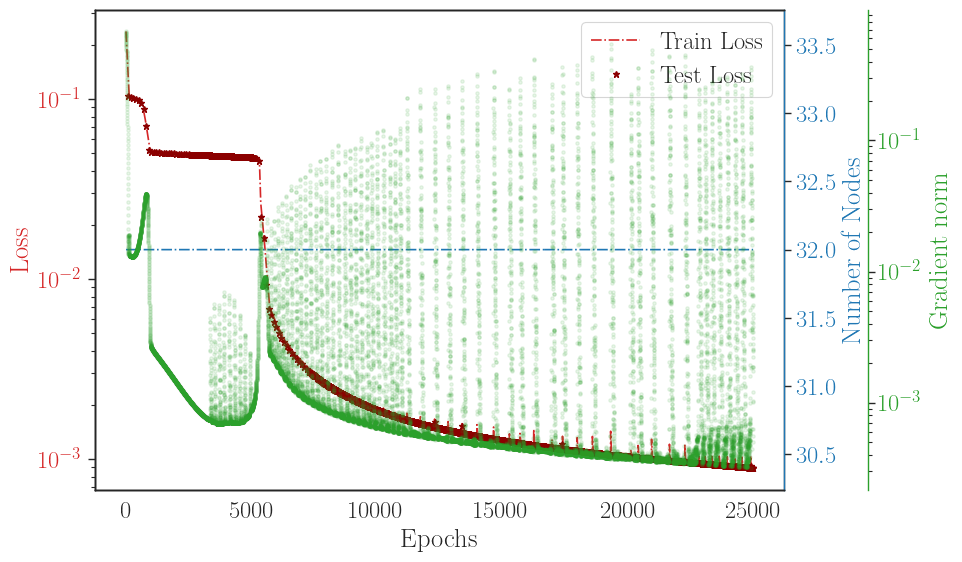

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_epochs, train_loss, "-.", color=color, label="Train Loss")
ax1.plot(test_epochs, test_loss, "*", color="darkred", label="Test Loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(node_epochs, n_neurons, "-.", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.spines['right'].set_color(color)


ax3 = ax1.twinx()

color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
ax3.plot(grad_epochs, grad_norm_val, '.', color=color, alpha = 0.1, label="Gradient Norm")
ax3.set_ylabel('Gradient norm', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_yscale("log")
ax3.spines['right'].set_color(color)

# ax1.set_xscale("log")

fig.tight_layout()
plt.savefig(f"{fig_folder}/loss_curve.png")
plt.savefig(f"{fig_folder}/loss_curve.pdf")
plt.savefig(f"{fig_folder}/loss_curve.svg", format='svg', bbox_inches='tight')

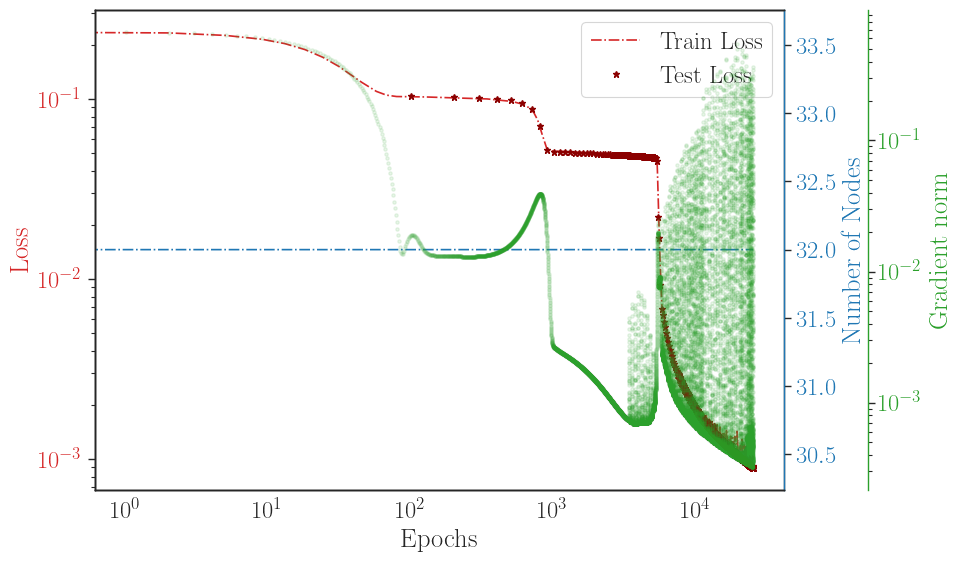

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(train_epochs, train_loss, "-.", color=color, label="Train Loss")
ax1.plot(test_epochs, test_loss, "*", color="darkred", label="Test Loss")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(node_epochs, n_neurons, "-.", color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.spines['right'].set_color(color)


ax3 = ax1.twinx()

color = 'tab:green'
ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
ax3.plot(grad_epochs, grad_norm_val, '.', color=color, alpha = 0.1, label="Gradient Norm")
ax3.set_ylabel('Gradient norm', color=color)
ax3.tick_params(axis='y', labelcolor=color)
ax3.set_yscale("log")
ax3.spines['right'].set_color(color)

ax1.set_xscale("log")
fig.tight_layout()
plt.savefig(f"{fig_folder}/loss_curve_loglog.png")
plt.savefig(f"{fig_folder}/loss_curve_loglog.pdf")
plt.savefig(f"{fig_folder}/loss_curve_loglog.svg", format='svg', bbox_inches='tight')

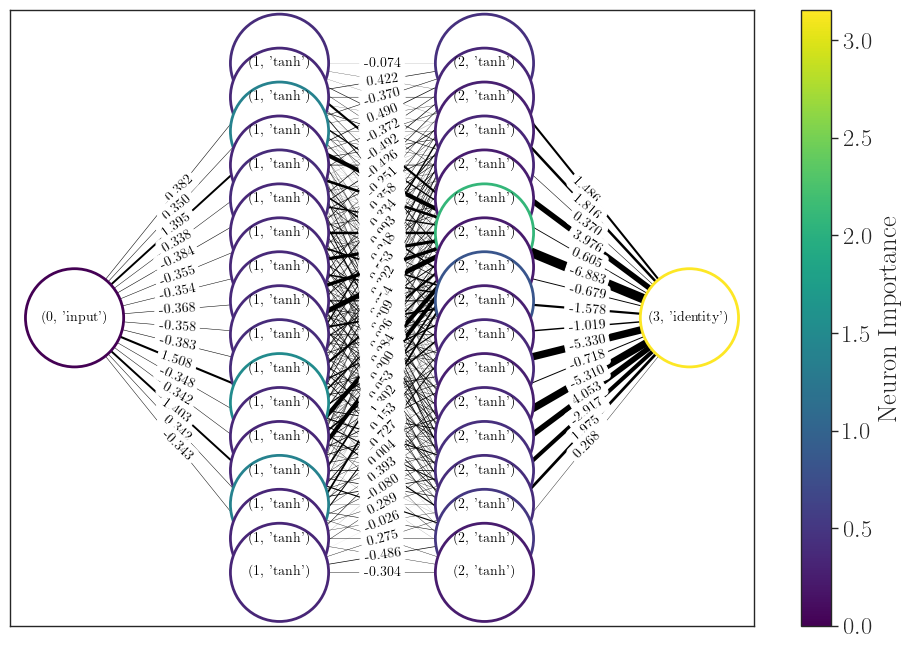

In [ ]:
G, neuron_labels, neuron_importances = mlp.visualize_graph()
fig = mlp_plot(G, neuron_labels, neuron_importances)
plt.savefig(f"{fig_folder}/final_graph.png")
plt.savefig(f"{fig_folder}/final_graph.pdf")
plt.savefig(f"{fig_folder}/final_graph.svg", format='svg', bbox_inches='tight')